In [9]:
from mipy.data import saved_data, saved_acquisition_schemes
import matplotlib.pyplot as plt
%matplotlib inline
data = saved_data.wu_minn_hcp_coronal_slice()
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


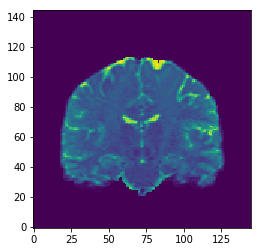

In [4]:
plt.imshow(data[:,0,:,0].T, origin=True)

In [11]:
sub_image = data[70:90,:, 70:90]

In [7]:
from mipy.signal_models import cylinder_models, gaussian_models
from mipy.core import modeling_framework

In [6]:
ball = gaussian_models.G3Ball()
stick1 = cylinder_models.C1Stick()
stick2 = cylinder_models.C1Stick()

In [10]:
BAS_crossing_mod = modeling_framework.MultiCompartmentMicrostructureModel(
    scheme, models=[ball, stick1, stick2])

In [12]:
BAS_crossing_fit = BAS_crossing_mod.fit(
    data=sub_image, mask=sub_image[..., 0]>0, solver='mix')

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 217.338178158 seconds.
Average of 0.543345445395 seconds per voxel.


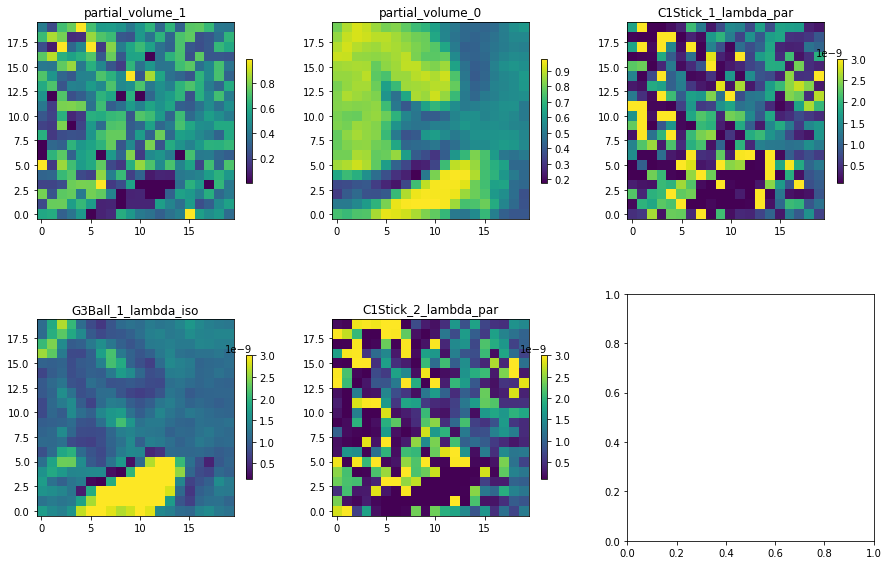

In [13]:
fitted_parameters = BAS_crossing_fit.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1